<a href="https://colab.research.google.com/github/sharmakhushi28/ml-on-fpga/blob/main/ML_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q tensorflow numpy matplotlib scikit-learn

In [ ]:
import os, numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
import tensorflow as tf
from tensorflow.keras import layers, models

print("TensorFlow:", tf.__version__)
print("GPU:", tf.config.list_physical_devices('GPU'))

TensorFlow: 2.19.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
data_path = "/content/sample_data/Wafer_Map_Datasets.npz"
assert os.path.exists(data_path), "Upload Wafer_Map_Datasets.npz into /content first!"

data = np.load(data_path, allow_pickle=True)
X = data["arr_0"]   # wafer maps
y = data["arr_1"]   # multi-label defect vectors

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Example label:", y[0])
print("Unique label rows:", np.unique(y, axis=0).shape[0])

X shape: (38015, 52, 52)
y shape: (38015, 8)
Example label: [1 0 1 0 0 0 1 0]
Unique label rows: 38


In [ ]:
# Normalize pixels to [0,1]
X = X.astype("float32") / 255.0

# Add channel dimension for CNN (grayscale → 1 channel)
X = np.expand_dims(X, axis=-1)   # (N, 52, 52, 1)

# Train / temp split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# Temp → validation + test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)

Train: (28511, 52, 52, 1) (28511, 8)
Val:   (4752, 52, 52, 1) (4752, 8)
Test:  (4752, 52, 52, 1) (4752, 8)


In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.10,
    height_shift_range=0.10,
    zoom_range=0.10,
    fill_mode='nearest'
)
datagen.fit(X_train)

In [ ]:
def build_model():
    model = models.Sequential([
        layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(52,52,1)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.Conv2D(128, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.Conv2D(128, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.4),

        layers.Dense(8, activation='sigmoid')  # 8 independent defect labels
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.BinaryAccuracy(name="bin_acc")]
    )
    return model

model = build_model()
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 52, 52, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 52, 52, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 26, 26, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 13, 13, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 13, 13, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 538,888 (2.06 MB)

 Trainable params: 538,184 (2.05 MB)

 Non-trainable params: 704 (2.75 KB)

In [ ]:
checkpoint_path = "/content/sample_data/best_wafer_cnn.keras"

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=5, restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1
    )
]

In [ ]:
batch_size = 32
epochs = 30   # EarlyStopping will stop earlier if no improvement

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

Epoch 1/30
  4/891 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - bin_acc: 0.9940 - loss: 0.0202

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


889/891 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - bin_acc: 0.9909 - loss: 0.0304
Epoch 1: val_loss did not improve from 0.05026
891/891 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - bin_acc: 0.9909 - loss: 0.0304 - val_bin_acc: 0.8806 - val_loss: 0.7465
Epoch 2/30
726/891 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - bin_acc: 0.9918 - loss: 0.0285

KeyboardInterrupt: 

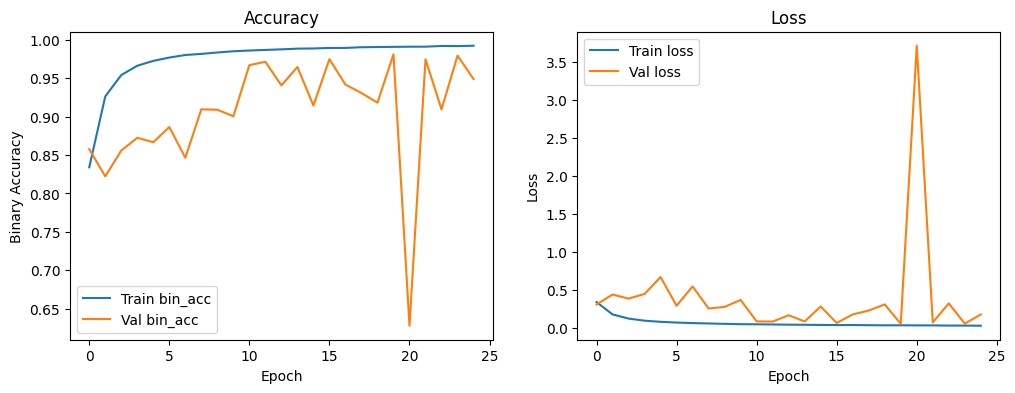

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['bin_acc'], label='Train bin_acc')
plt.plot(history.history['val_bin_acc'], label='Val bin_acc')
plt.xlabel('Epoch'); plt.ylabel('Binary Accuracy')
plt.legend(); plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend(); plt.title('Loss')
plt.show()

In [ ]:
# Load best weights (if not already)
if os.path.exists(checkpoint_path):
    model.load_weights(checkpoint_path)

test_loss, test_bin_acc = model.evaluate(X_test, y_test, verbose=1)
print("Test binary accuracy:", test_bin_acc)
print("Test loss:", test_loss)

# Multi-label predictions
y_pred_probs = model.predict(X_test, verbose=1)

# Threshold; you can tune 0.5 → 0.4 etc.
threshold = 0.4
y_pred = (y_pred_probs >= threshold).astype(int)

# F1 score (macro averages over 8 labels)
f1 = f1_score(y_test, y_pred, average='macro')
print("Macro F1 score:", f1)

149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - bin_acc: 0.9805 - loss: 0.0523
Test binary accuracy: 0.9799821376800537
Test loss: 0.05271149054169655
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Macro F1 score: 0.9512644173070774


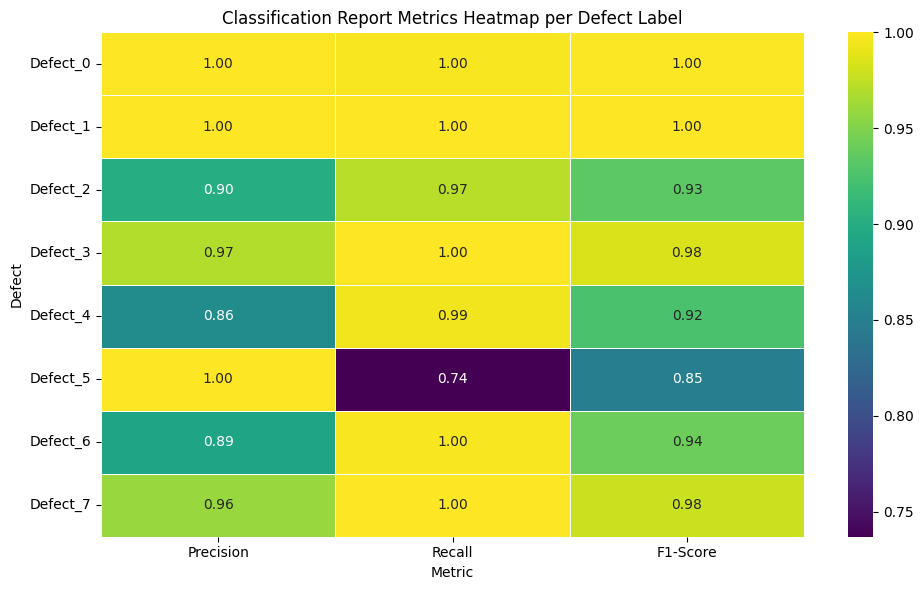

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

# Generate the classification report as a dictionary
report_dict = classification_report(
    y_test.reshape(-1, 8),
    y_pred.reshape(-1, 8),
    target_names=[f"Defect_{i}" for i in range(8)],
    output_dict=True,
    zero_division=0 # Handle zero division warnings gracefully
)

# Extract metrics for each defect label
metrics_data = []
for i in range(8):
    defect_name = f"Defect_{i}"
    if defect_name in report_dict:
        metrics_data.append({
            'Defect': defect_name,
            'Precision': report_dict[defect_name]['precision'],
            'Recall': report_dict[defect_name]['recall'],
            'F1-Score': report_dict[defect_name]['f1-score']
        })

# Convert to DataFrame for easier plotting
df_metrics = pd.DataFrame(metrics_data).set_index('Defect')

plt.figure(figsize=(10, 6))
sns.heatmap(df_metrics[['Precision', 'Recall', 'F1-Score']], annot=True, cmap='viridis', fmt=".2f", linewidths=.5)
plt.title('Classification Report Metrics Heatmap per Defect Label')
plt.ylabel('Defect')
plt.xlabel('Metric')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
print(classification_report(
    y_test.reshape(-1, 8),
    y_pred.reshape(-1, 8),
    target_names=[f"Defect_{i}" for i in range(8)]
))

NameError: name 'classification_report' is not defined

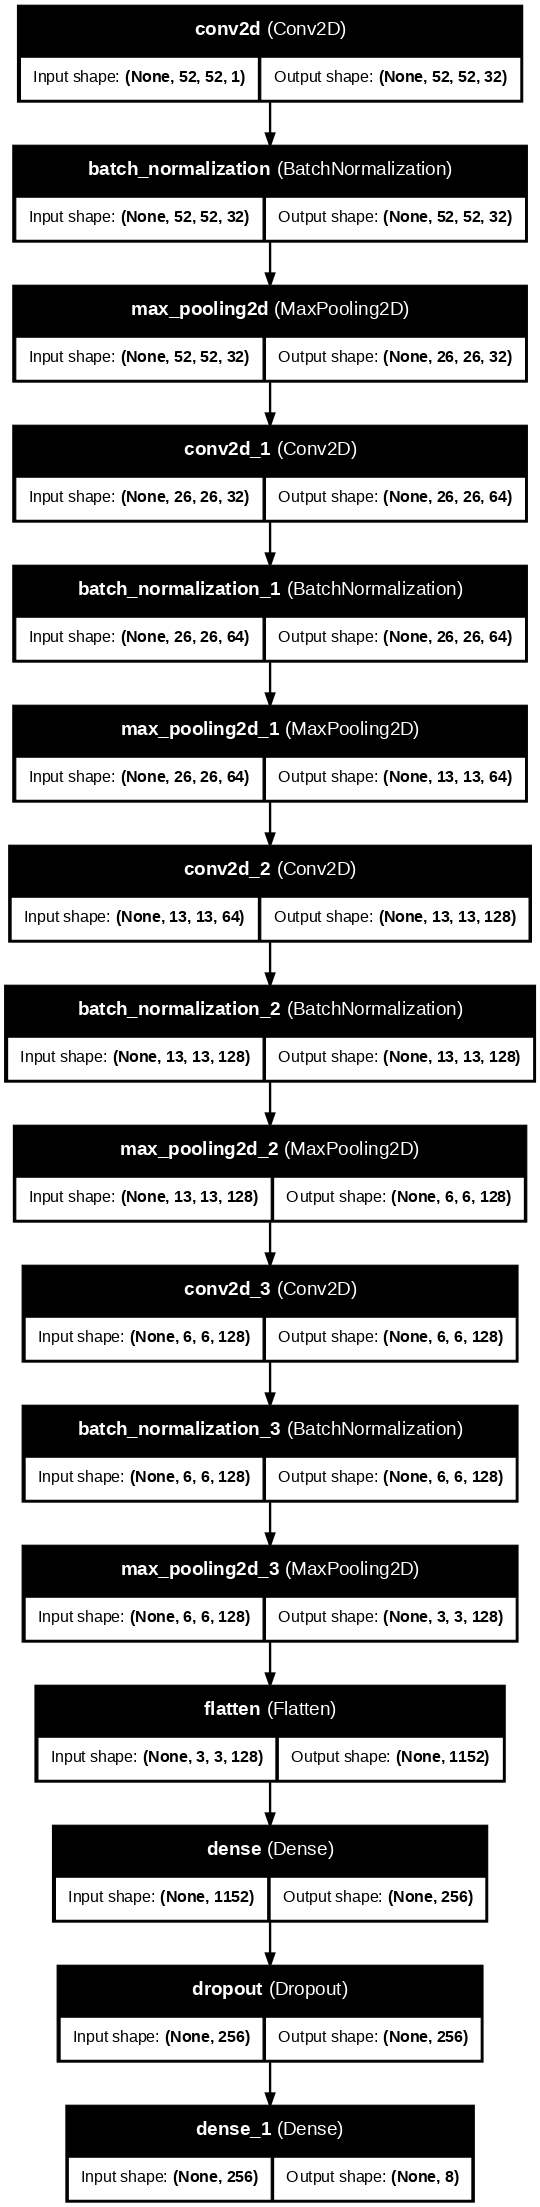

In [ ]:
import tensorflow as tf


tf.keras.utils.plot_model(
    model,
    to_file='model_architecture_horizontal.png', # Save to a new file name
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    dpi=84
)

# Display the image in the notebook
from IPython.display import Image
Image(filename='model_architecture_horizontal.png')

/tmp/ipython-input-2288655515.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Defect_Combination', y='Count', data=df_true_combinations_counts, palette='viridis')
/tmp/ipython-input-2288655515.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Defect_Combination', y='Count', data=df_pred_combinations_counts, palette='viridis')


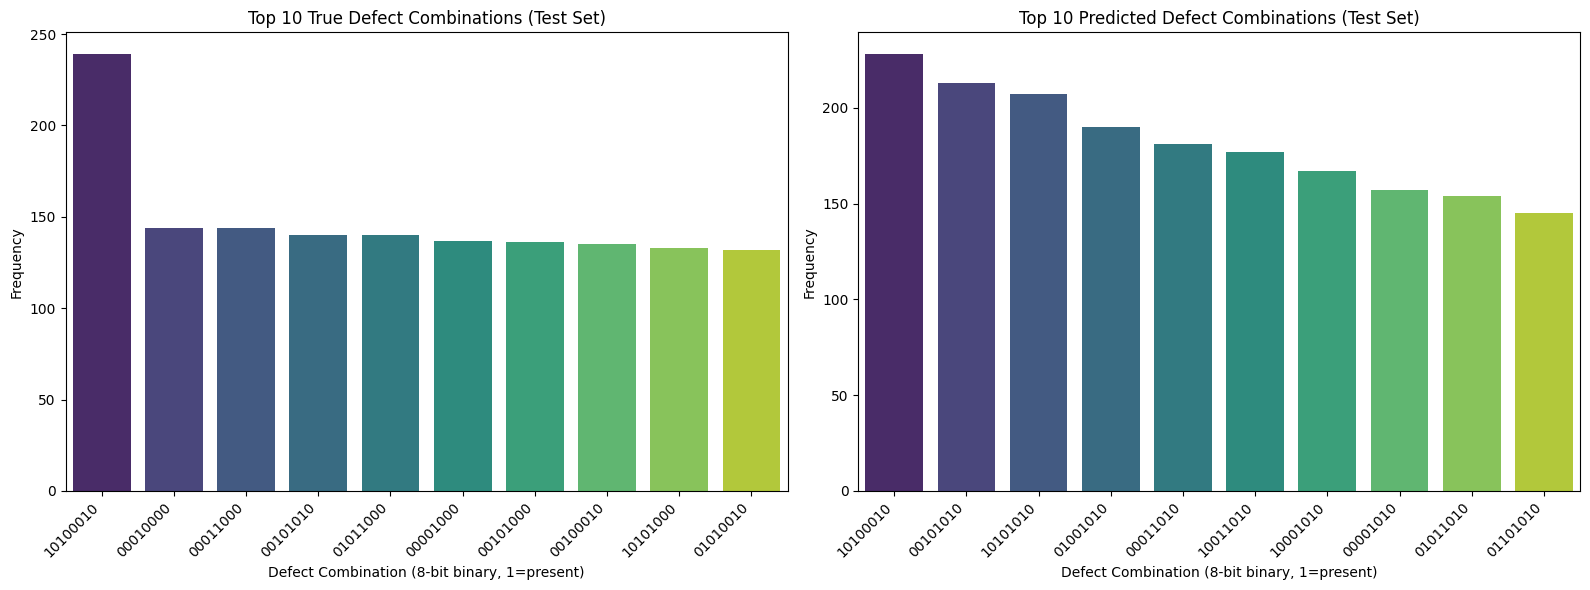

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Combine true labels for analysis
y_combined = np.hstack((y_test, y_pred))

# Convert to DataFrame for easier manipulation
df_combined = pd.DataFrame(y_combined, columns=[f'True_Defect_{i}' for i in range(8)] + [f'Pred_Defect_{i}' for i in range(8)])

# Get unique combinations of true defects
df_true_combinations = df_combined[[f'True_Defect_{i}' for i in range(8)]]
df_true_combinations_counts = df_true_combinations.apply(lambda x: ''.join(x.astype(str)), axis=1).value_counts().reset_index()
df_true_combinations_counts.columns = ['Defect_Combination', 'Count']

# Get unique combinations of predicted defects
df_pred_combinations = df_combined[[f'Pred_Defect_{i}' for i in range(8)]]
df_pred_combinations_counts = df_pred_combinations.apply(lambda x: ''.join(x.astype(str)), axis=1).value_counts().reset_index()
df_pred_combinations_counts.columns = ['Defect_Combination', 'Count']

# Limit to top N combinations for clarity if too many
N = 10
df_true_combinations_counts = df_true_combinations_counts.head(N)
df_pred_combinations_counts = df_pred_combinations_counts.head(N)

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='Defect_Combination', y='Count', data=df_true_combinations_counts, palette='viridis')
plt.title(f'Top {N} True Defect Combinations (Test Set)')
plt.xlabel('Defect Combination (8-bit binary, 1=present)')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 2, 2)
sns.barplot(x='Defect_Combination', y='Count', data=df_pred_combinations_counts, palette='viridis')
plt.title(f'Top {N} Predicted Defect Combinations (Test Set)')
plt.xlabel('Defect Combination (8-bit binary, 1=present)')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

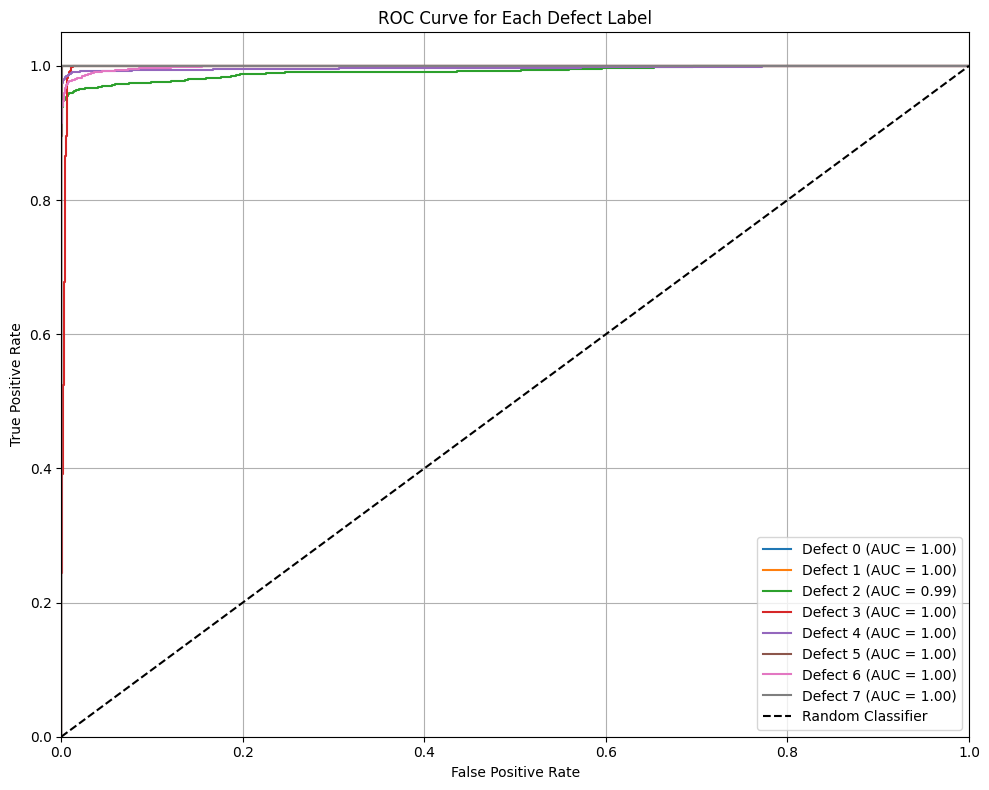

In [ ]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 8))

for i in range(y_test.shape[1]): # Iterate over each defect label
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Defect {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Defect Label')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Predict probabilities
y_pred_prob = model.predict(X_test)

# Apply threshold
threshold = 0.4
y_pred = (y_pred_prob >= threshold).astype(int)


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


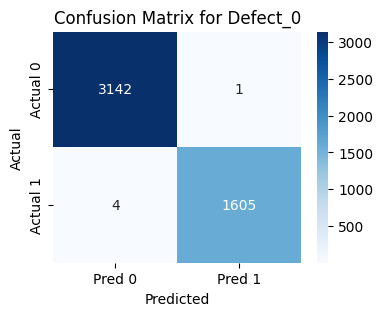

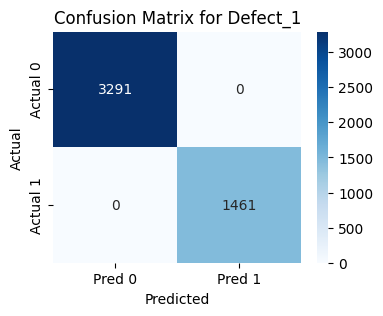

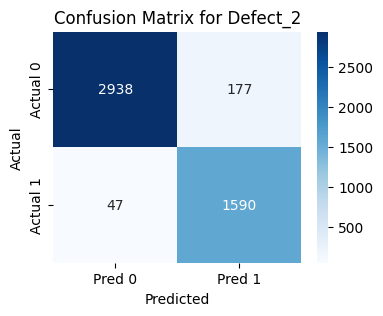

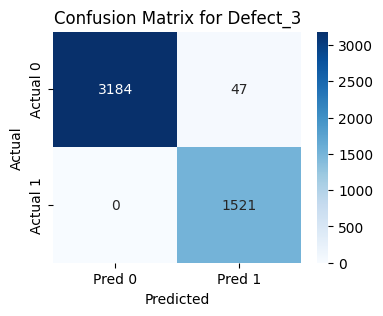

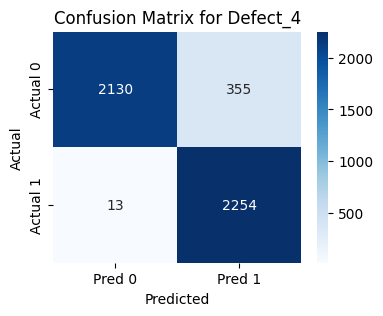

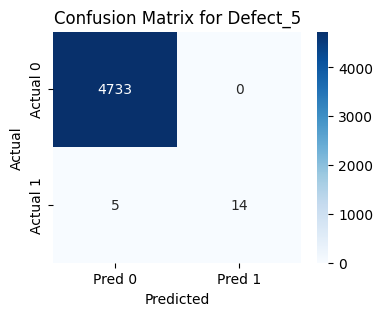

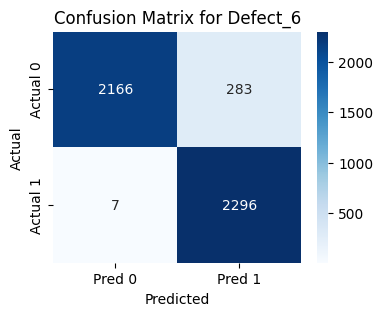

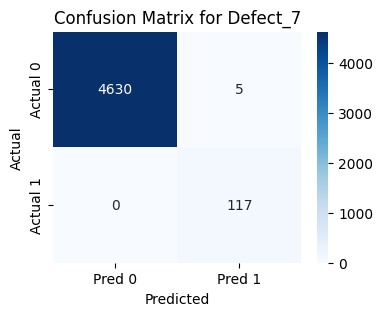

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

num_classes = y_test.shape[1]      # should be 8
class_names = [f"Defect_{i}" for i in range(num_classes)]

for i in range(num_classes):
    cm = confusion_matrix(y_test[:, i], y_pred[:, i])

    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Pred 0", "Pred 1"],
                yticklabels=["Actual 0", "Actual 1"])
    plt.title(f"Confusion Matrix for {class_names[i]}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


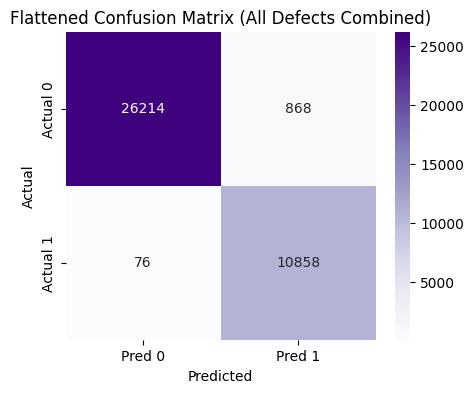

In [ ]:
from sklearn.metrics import confusion_matrix

y_test_flat = y_test.reshape(-1)
y_pred_flat = y_pred.reshape(-1)

cm = confusion_matrix(y_test_flat, y_pred_flat)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["Actual 0", "Actual 1"])
plt.title("Flattened Confusion Matrix (All Defects Combined)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


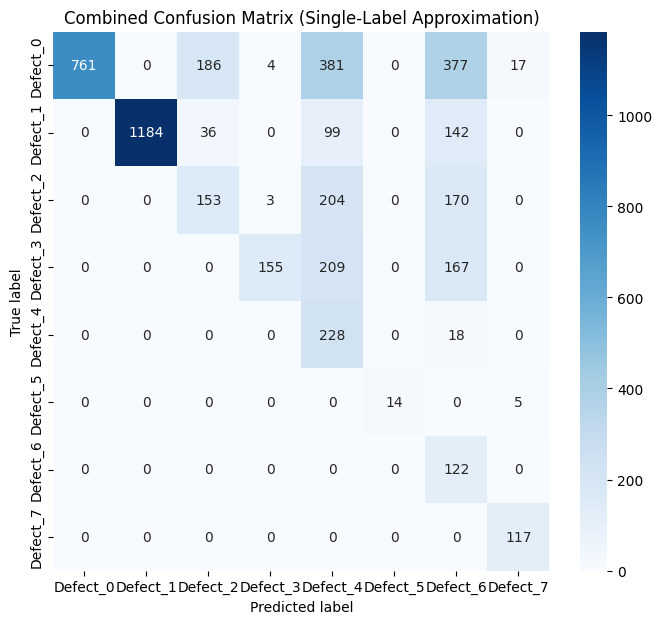

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Convert multi-label to single-label using argmax
y_true_single = np.argmax(y_test, axis=1)
y_pred_single = np.argmax(y_pred_probs, axis=1)

# Class names (modify if needed)
class_names = [f"Defect_{i}" for i in range(8)]

# Compute confusion matrix
cm = confusion_matrix(y_true_single, y_pred_single)

# Plot
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Combined Confusion Matrix (Single-Label Approximation)")
plt.show()
